In [1]:
import xenonpy
import pickle
from rdkit.Chem import AllChem
from plotools import *
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
%run ../samples/tools.ipynb
np.random.seed(202309)

In [2]:
with open('../models/v2/0/model_CO2.pkl', 'rb') as f:
    model_CO2 = pickle.load(f)
with open('../models/v2/0/model_N2.pkl', 'rb') as f:
    model_N2 = pickle.load(f)

In [3]:
data_collect = pd.read_csv('../../data/poly_dataset_imputation.csv')
data_collect_part = data_collect.loc[:, ['SMILES', 'log10_He_Bayes', 'log10_H2_Bayes', 'log10_N2_Bayes', 'log10_O2_Bayes', 'log10_CO2_Bayes', 'log10_CH4_Bayes']]
data_collect_part = data_collect_part.rename(columns={'log10_He_Bayes': 'He', 'log10_H2_Bayes': 'H2', 'log10_N2_Bayes': 'N2', 'log10_O2_Bayes': 'O2', 'log10_CO2_Bayes': 'CO2', 'log10_CH4_Bayes': 'CH4'})
data_D = pd.read_csv('../../data/datasetD_predict.csv')
train_data = pd.concat([data_collect_part, data_D], axis=0)

In [4]:
data = pd.read_csv('../../data/ll/ll_CO2_N2-2.csv')
data['ll'] = np.exp(data['k_CO2_N2'])
initdata = data.nlargest(1000, 'll')

<module 'matplotlib.pyplot' from '/home/naoren/anaconda3/envs/xenonpy/lib/python3.9/site-packages/matplotlib/pyplot.py'>

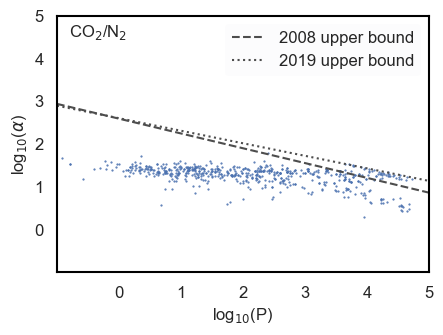

In [5]:
train_data = initdata.copy()
draw_properties(data_collect_part, 'CO2', 'N2')

In [6]:
from xenonpy.descriptor import fingerprint

fp_class = fingerprint.ECFP(radius=2, input_type='smiles')
fp = fp_class.transform(train_data['SMILES'], return_type='df')
fp_collect = fp_class.transform(data_collect_part['SMILES'], return_type='df')

In [7]:
train_data['CO2'] = model_CO2.predict(fp)
train_data['N2'] = model_N2.predict(fp)
train_data['alpha_CO2_N2'] = train_data['CO2'] - train_data['N2']
train_data['k_CO2_N2'] = 1.2933*train_data['CO2'] - train_data['N2']

In [8]:
%%time
from xenonpy.inverse.iqspr import GaussianLogLikelihood
from xenonpy.inverse.iqspr import NGram
from sklearn.linear_model import BayesianRidge

prop = ['CO2','N2','k_CO2_N2']
target_range = {'CO2':(-8,8), 'N2':(-8,8), 'k_CO2_N2': (2.6044, np.inf)}
custom_model = {'CO2':model_CO2, 'N2':model_N2, 'k_CO2_N2': BayesianRidge(alpha_1=1e-6, alpha_2=1e-6, lambda_1=1e-6, lambda_2=1e-6)}

prd_mdls = GaussianLogLikelihood(descriptor=fp_class, targets = target_range, **custom_model)
prd_mdls._mdl['k_CO2_N2'].fit(fp_collect, data_collect_part['k_CO2_N2'])

prd_mdls.update_targets(reset=True,**target_range)

CPU times: user 10.1 s, sys: 23 s, total: 33.1 s
Wall time: 2.11 s


In [9]:
n_gram = joblib.load('./ngram_all.xz')

In [10]:
np.random.seed(202309) # fix the random seed
cans = [Chem.MolToSmiles(Chem.MolFromSmiles(smi)) for i, smi in enumerate(train_data['SMILES'])]
init_samples = train_data['SMILES'].to_numpy()

pre_beta = np.linspace(-5,5,80)
sig = 1 / (1 + np.exp(-pre_beta))
beta = np.hstack([sig, np.linspace(0.9934,1,10), np.linspace(1,1,10)])

In [11]:
%%time
from xenonpy.inverse.iqspr import IQSPR

iqspr_reorder = IQSPR(estimator=prd_mdls, modifier=n_gram)

np.random.seed(202309)

# main loop of iQSPR

iqspr_samples1, iqspr_loglike1, iqspr_prob1, iqspr_freq1 = [], [], [], []
for s, ll, p, freq in iqspr_reorder(init_samples, beta, yield_lpf=True):
    iqspr_samples1.append(s)
    iqspr_loglike1.append(ll)
    iqspr_prob1.append(p)
    iqspr_freq1.append(freq)
    
# record all outputs

iqspr_results_reorder = {
    "samples": iqspr_samples1,
    "loglike": iqspr_loglike1,
    "prob": iqspr_prob1,
    "freq": iqspr_freq1,
    "beta": beta
}
# save results
with open('iQSPR_results_CN_bayes-3.obj', 'wb') as f:
    pk.dump(iqspr_results_reorder, f)

[12:28:50] Can't kekulize mol.  Unkekulized atoms: 68 69 70 71 72 73 74 75 76 78 79 80 85 90 91 92 96 97 98 99
[12:28:52] Can't kekulize mol.  Unkekulized atoms: 39 40 41 43 45
[12:28:56] Can't kekulize mol.  Unkekulized atoms: 36 37 38 40 41 71 73
[12:28:59] Explicit valence for atom # 82 C, 5, is greater than permitted
[12:29:04] Can't kekulize mol.  Unkekulized atoms: 102 103 104 106 107 109 110
[12:29:06] Can't kekulize mol.  Unkekulized atoms: 35 36 38 39 61
[12:29:06] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 22 24
[12:29:07] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6 7 11 12 13 15 48 53 54 56 57 58 59 60 61
[12:29:11] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19 21 22 23 64 65 66 68 69
[12:29:13] Can't kekulize mol.  Unkekulized atoms: 1 2 3 8 58 81 83
[12:29:14] Can't kekulize mol.  Unkekulized atoms: 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 125 126 127 128
[12:29:14] Can't kekulize mol.  Unkekulize

CPU times: user 2h 3min 16s, sys: 3min 39s, total: 2h 6min 55s
Wall time: 2h 2min 27s


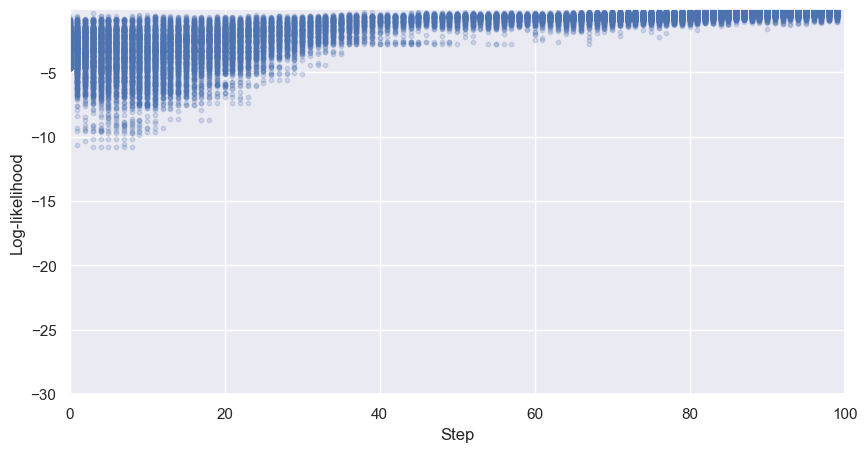

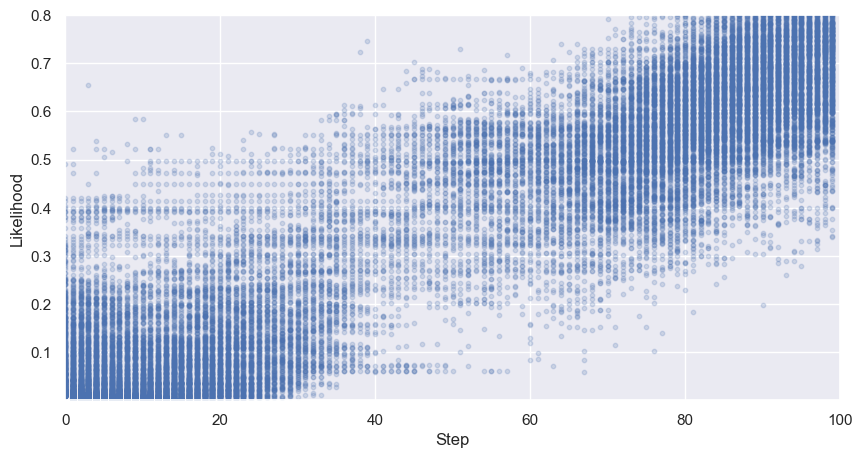

In [12]:
# plot the likelihood evolution

# set up the min and max boundary for the plots
tmp_list = [x.sum(axis = 1, skipna = True).values for x in iqspr_results_reorder["loglike"]]
flat_list = np.asarray([item for sublist in tmp_list for item in sublist])
y_max, y_min = max(flat_list), min(flat_list)

_ = plt.figure(figsize=(10,5))
_ = plt.xlim(0,len(iqspr_results_reorder["loglike"]))
_ = plt.ylim(-30,y_max)
_ = plt.xlabel('Step')
_ = plt.ylabel('Log-likelihood')
for i, ll in enumerate(tmp_list):
    _ = plt.scatter([i]*len(ll), ll ,s=10, c='b', alpha=0.2)
_ = plt.show()
#plt.savefig('iqspr_loglike_reorder.png',dpi = 500)
#plt.close()

y_max, y_min = np.exp(y_max), np.exp(y_min)
_ = plt.figure(figsize=(10,5))
_ = plt.xlim(0,len(iqspr_results_reorder["loglike"]))
_ = plt.ylim(y_min,0.8)
_ = plt.xlabel('Step')
_ = plt.ylabel('Likelihood')
for i, ll in enumerate(tmp_list):
    _ = plt.scatter([i]*len(ll), np.exp(ll) ,s=10, c='b', alpha=0.2)
_ = plt.show()
#plt.savefig('iqspr_like_reorder.png',dpi = 500)
#plt.close()

In [13]:
x_mean, x_std, y_mean, y_std = [], [], [], []
r_std = []
k_std = []
FPs_samples = []
for i, smis in enumerate(iqspr_results_reorder["samples"]):
    tmp_fps = fp_class.transform(smis)
    FPs_samples.append(tmp_fps)

    tmp1, tmp2 = prd_mdls['CO2'].predict(tmp_fps, return_std=True)
    x_mean.append(tmp1)
    x_std.append(tmp2)

    tmp3, tmp4 = prd_mdls['N2'].predict(tmp_fps, return_std=True)

    y_mean.append(tmp1-tmp3)
    y_std.append(np.sqrt(np.square(tmp2)+np.square(tmp4)))

    r_std.append([np.sqrt(x_std[-1][i]**2 + y_std[-1][i]**2) for i in range(len(x_std[-1]))])
    k_std.append([np.sqrt(1.2933**2 * x_std[-1][i]**2 + y_std[-1][i]**2) for i in range(len(x_std[-1]))])

# flatten the list for max/min calculation
flat_list = [item for sublist in r_std for item in sublist]
print('Range of std. dev.: (%.4f,%.4f)' % (min(flat_list),max(flat_list)))

Range of std. dev.: (0.7577,2.3961)


In [14]:
%%time

import os

# prepare a folder to save all the figures
ini_dir = './test_CO2N2_bayes_3/'
if not os.path.exists(ini_dir):
    os.makedirs(ini_dir)
flat_list = np.asarray([item for sublist in r_std for item in sublist])
s_max, s_min = max(flat_list), min(flat_list)
flat_list = np.concatenate((train_data['CO2'],
    np.asarray([item for sublist in x_mean for item in sublist]).flatten()))
x_max, x_min = max(flat_list), min(flat_list)
flat_list = np.concatenate((train_data['alpha_CO2_N2'],
    np.asarray([item for sublist in y_mean for item in sublist]).flatten()))
y_max, y_min = max(flat_list), min(flat_list)
tmp_beta = iqspr_results_reorder["beta"]


for i in range(len(r_std)):
    dot_size = 45*((np.asarray(r_std[i])-s_min)/(s_max-s_min)) + 5

    fig, ax = plt.subplots(figsize=(3.33,3.33))
    ax.set_facecolor('white')
    kuang = ['top','bottom','left','right']
    for j in kuang:
        ax.spines[j].set_color('black')
    _ = plt.scatter(train_data['CO2'], train_data['alpha_CO2_N2'],s=12, c='b', alpha=0.2)
    _ = plt.scatter(x_mean[i], y_mean[i],s=dot_size, c='r', alpha=0.3)
#     _ = plt.title('Step: %i (beta = %.3f)' % (i,tmp_beta[i]))
    ax.set_xticks(np.arange(0,5.01))
    ax.set_yticks(np.arange(0,5.01))
    ax.set_xlim(-0.5, 5.01)
    ax.set_ylim(-0.5, 5.01)
    ax.set_xlabel('log$_{10}$(P)', fontsize=12)
    ax.set_ylabel(r'log$_{10}$(${\alpha}$)', fontsize=12)
    plt.tick_params(labelsize=12)
    ax.axline((0,2.5938), slope=-0.3463,ls="--", c=".3", label='2008 upper bound')
    ax.axline((0,2.6044), slope=-0.2933,ls=":", c=".3",  label='2019 upper bound')
    ax.text(-0.2,4.45, ('Step: %i (beta = %.3f)' % (i+1,tmp_beta[i])))
    leg = ax.legend(fontsize=12, loc=3, framealpha=0.1)
    leg.get_frame().set_linewidth(0.0)

    _ = plt.savefig(ini_dir+'Step_%02i.png' % i,dpi = 300,  bbox_inches = 'tight')
    _ = plt.close()

CPU times: user 33.8 s, sys: 11 s, total: 44.9 s
Wall time: 31.2 s
